In [139]:
import sys
sys.path.insert(0,'C:\\users\\alexa\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import datetime
from scipy import stats
from scipy.optimize import minimize
from scipy import optimize
import matplotlib.ticker as ticker

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, Tuple

"""
Own packages
"""

from codelib.statistics import calculate_cornish_fisher_percentile
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_std, calculate_risk_contributions_std
from codelib.portfolio_optimization.risk_metrics import calculate_normal_cond_value_at_risk, calculate_normal_value_at_risk
from codelib.portfolio_optimization.risk_metrics import calculate_normal_port_cond_value_at_risk, calculate_normal_port_value_at_risk
from codelib.portfolio_optimization.risk_metrics import calculate_conditional_value_at_risk, calculate_value_at_risk
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_cvar, calculate_risk_contributions_cvar
from codelib.portfolio_optimization.mean_variance import portfolio_mean, portfolio_std, portfolio_variance
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_std, calculate_risk_contributions_normal_var, calculate_marginal_sharpe
from codelib.visualization.base import risk_waterfall_chart
from codelib.portfolio_optimization.risk_metrics import drawdown, maxdrawdown

from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix
from codelib.statistics.robust_covariance import marchencko_pastur_bounds, marchencko_pastur_density, fitting_error, crem_denoised_corr_mat

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
"""
Question 2
"""

mu = np.array([0.019, 0.022, 0.049, 0.043, 0.061, 0.083, 0.102, 0.056, 0.041, 0.038])
vols = np.array([0.037, 0.055, 0.119, 0.107, 0.153, 0.217, 0.204, 0.14, 0.108, 0.094])
corr_mat = np.array([[1.0, 0.6, 0.1, 0.3, -0.1, -0.1, -0.2, -0.1, -0.1, -0.1],
                     [0.6, 1.0, 0.6, 0.6, 0.2, 0.2, 0.2, 0.1, 0.1, 0.3],
                     [0.1, 0.6, 1.0, 0.7, 0.7, 0.6, 0.6, 0.4, 0.3, 0.7],
                     [0.3, 0.6, 0.7, 1.0, 0.5, 0.6, 0.4, 0.2, 0.2, 0.5],
                     [-0.1, 0.2, 0.7, 0.5, 1.0, 0.7, 0.8, 0.4, 0.4, 0.8],
                     [-0.1, 0.2, 0.6, 0.6, 0.7, 1.0, 0.7, 0.4, 0.4, 0.7],
                     [-0.2, 0.2, 0.6, 0.4, 0.8, 0.7, 1.0, 0.4, 0.4, 0.7],
                     [-0.1, 0.1, 0.4, 0.2, 0.4, 0.4, 0.4, 1.0, 0.3, 0.4],
                     [-0.1, 0.1, 0.3, 0.2, 0.4, 0.4, 0.4, 0.3, 1.0, 0.4],
                     [-0.1, 0.3, 0.7, 0.5, 0.8, 0.7, 0.7, 0.4, 0.4, 1.0]])

cov_mat = np.outer(vols, vols) * corr_mat
cov_mat

array([[ 0.001369 ,  0.001221 ,  0.0004403,  0.0011877, -0.0005661,
        -0.0008029, -0.0015096, -0.000518 , -0.0003996, -0.0003478],
       [ 0.001221 ,  0.003025 ,  0.003927 ,  0.003531 ,  0.001683 ,
         0.002387 ,  0.002244 ,  0.00077  ,  0.000594 ,  0.001551 ],
       [ 0.0004403,  0.003927 ,  0.014161 ,  0.0089131,  0.0127449,
         0.0154938,  0.0145656,  0.006664 ,  0.0038556,  0.0078302],
       [ 0.0011877,  0.003531 ,  0.0089131,  0.011449 ,  0.0081855,
         0.0139314,  0.0087312,  0.002996 ,  0.0023112,  0.005029 ],
       [-0.0005661,  0.001683 ,  0.0127449,  0.0081855,  0.023409 ,
         0.0232407,  0.0249696,  0.008568 ,  0.0066096,  0.0115056],
       [-0.0008029,  0.002387 ,  0.0154938,  0.0139314,  0.0232407,
         0.047089 ,  0.0309876,  0.012152 ,  0.0093744,  0.0142786],
       [-0.0015096,  0.002244 ,  0.0145656,  0.0087312,  0.0249696,
         0.0309876,  0.041616 ,  0.011424 ,  0.0088128,  0.0134232],
       [-0.000518 ,  0.00077  ,  0.006664

In [141]:
def simulate_asset_prices(mu: np.ndarray, cov_mat: np.ndarray,
                          horizon: float, dt: float, num_sim: int,
                          transform_input: bool=False) -> np.ndarray:
    
    """
    Simulates asset prices
    
    Parameters
    ----------
    mu: 
        Expected log-returns. 
    cov_mat: 
        Covariance matrix of log-returns. 
    horizon: 
        Simulation horizon in years. 
    dt: 
        Time step. 
    num_sim: 
        Number of simulations. 
    transform_input: 
        Boolean indicating whether to transform mu and cov_mat to time_step. 
    
    
    Returns
    -------
    np.ndarray
        Simulated asset prices  [num sim x num time steps x num_assets]. 
    
    
    """
    
    if transform_input:
        mu = mu * dt
        cov_mat = cov_mat * dt
        
    num_assets = len(mu)
    
    num_periods = int(horizon / dt)
    
    # allocate memory
    asset_prices = np.ones((num_sim, 1 + num_periods, num_assets))
    
    # simulate returns
    log_ret = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_periods))
    
    # transform returns to asset prices
    asset_prices[:, 1:, :] = np.exp(np.cumsum(log_ret, axis=1))
    
    return asset_prices

In [142]:
"""
Simulate asset prices
"""

num_sim = 5000
dt = 1.0
horizon = 5.0
mu = mu
cov_mat = cov_mat

time_points = np.arange(0.0, horizon + 0.01, dt)
asset_prices = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)

In [143]:
asset_0 = asset_prices[:,5:6,:1]
asset_1 = asset_prices[:,5:6,:1]
asset_2 = asset_prices[:,5:6,1:2]
asset_3 = asset_prices[:,5:6,2:3]
asset_4 = asset_prices[:,5:6,3:4]
asset_5 = asset_prices[:,5:6,4:5]
asset_6 = asset_prices[:,5:6,5:6]
asset_7 = asset_prices[:,5:6,6:7]
asset_8 = asset_prices[:,5:6,7:8]
asset_9 = asset_prices[:,5:6,8:9]
asset_10 = asset_prices[:,5:6,9:10]
A0 = asset_0[:,0,0]
A1 = asset_1[:,0,0]
A2 = asset_2[:,0,0]
A3 = asset_3[:,0,0]
A4 = asset_4[:,0,0]
a5 = asset_5[:,0,0]
a6 = asset_6[:,0,0]
a7 = asset_7[:,0,0]
a8 = asset_8[:,0,0]
a9 = asset_9[:,0,0]
a10 = asset_10[:,0,0]
data1 = [A0, A1,A2,A3,A4,a5,a6,a7,a8,a9,a10]

Text(0, 0.5, 'Prices')

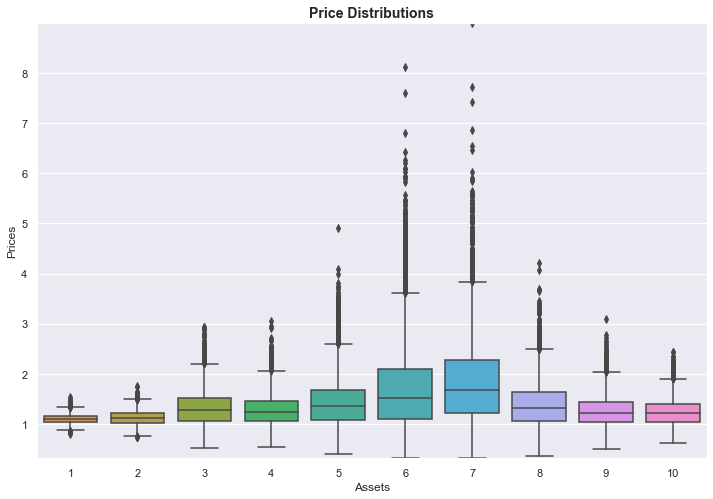

In [144]:
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.boxplot(data1)
ax.set_xlim(0.5,10.5)
ax.set_title('Price Distributions', fontsize=14, fontweight='bold')
ax.set_xlabel('Assets')
ax.set_ylabel('Prices')

In [145]:
asset_1 = asset_prices[:,5:6,:1]
asset_2 = asset_prices[:,5:6,1:2]
asset_3 = asset_prices[:,5:6,2:3]
asset_4 = asset_prices[:,5:6,3:4]
asset_5 = asset_prices[:,5:6,4:5]
asset_6 = asset_prices[:,5:6,5:6]
asset_7 = asset_prices[:,5:6,6:7]
asset_8 = asset_prices[:,5:6,7:8]
asset_9 = asset_prices[:,5:6,8:9]
asset_10 = asset_prices[:,5:6,9:10]
A1 = asset_1[:,0,0]
A2 = asset_2[:,0,0]
A3 = asset_3[:,0,0]
A4 = asset_4[:,0,0]
a5 = asset_5[:,0,0]
a6 = asset_6[:,0,0]
a7 = asset_7[:,0,0]
a8 = asset_8[:,0,0]
a9 = asset_9[:,0,0]
a10 = asset_10[:,0,0]
data2 = [A1,A2,A3,A4,a5,a6,a7,a8,a9,a10]

In [146]:
# Expected Covariance in 5 years

asset_prices_y5 = np.stack((A1,A2,A3,A4,a5,a6,a7,a8,a9,a10), axis=1)
asset_names = ['0','1','2','4','5','6','7','8','9','10']
asset_prices_y5_named = pd.DataFrame(asset_prices_y5, columns=asset_names)
asset_prices_y5_named

,0,1,2,4,5,6,7,8,9,10
0,1.145270,1.395731,1.925668,1.750994,1.804804,1.816044,2.017885,1.757333,1.676161,1.235023
1,1.042888,1.090185,1.452131,1.369601,1.302383,1.800664,1.354799,1.121690,1.507498,1.344417
2,1.276932,1.558859,2.515162,2.672096,2.549103,3.607366,3.417473,1.746240,1.369852,1.897114
3,1.144271,1.041773,1.017902,1.686824,2.163396,2.079905,1.833949,1.085578,1.513769,1.111275
4,0.958153,0.830683,0.864629,0.778957,1.816970,0.901395,1.774068,0.971622,1.261645,1.419172
...,...,...,...,...,...,...,...,...,...,...
4995,1.123558,1.093364,1.319512,1.169553,1.132704,1.120875,1.490995,1.567399,0.899097,1.187235
4996,1.090434,1.272072,1.632325,1.241008,2.020389,1.610886,2.479497,1.621314,1.282747,1.297299
4997,1.139393,0.879539,0.813691,0.784120,1.555631,0.900251,1.689533,1.001897,0.847461,0.932240
4998,1.043838,1.138376,2.042600,1.363260,1.970216,2.023571,3.188005,1.380500,1.212606,1.260669


In [198]:
"""
Buy and hold strategy for equally weighted portfolio
"""

port_w = np.ones(10) / 10

buy_and_hold_index = asset_prices @ port_w

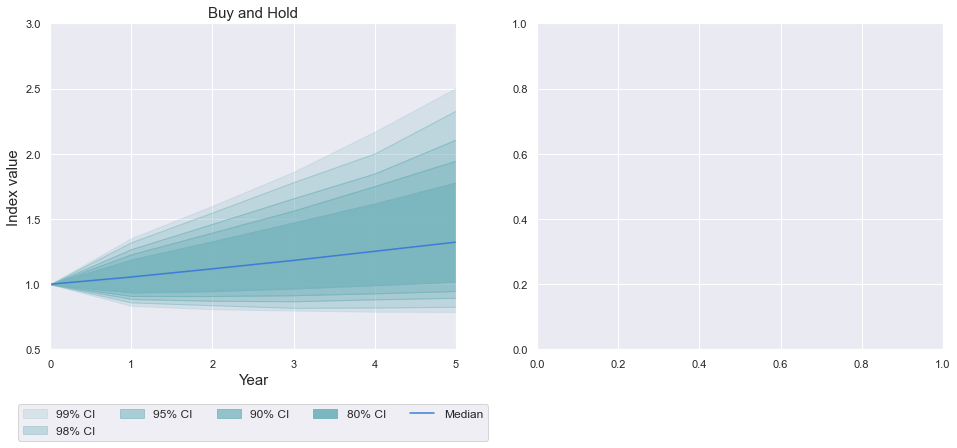

In [199]:
# calculate percentiles
percentiles_buy_and_hold = np.percentile(buy_and_hold_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fan_chart(time_points,
          percentiles_buy_and_hold,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[0])

ax[0].set_xlabel("Year", size=15)
ax[0].set_ylabel("Index value", size=15)
ax[0].set_title("Buy and Hold", size=15)
ax[0].set_ylim([0.5, 3.0])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

In [200]:
# Starting Wealth
a0 = 500000

In [201]:
# Defining array of prices of all simulations each year for asset 5
a5_y0 = asset_prices[:,0:1,4:5]
a5_y1 = asset_prices[:,1:2,4:5]
a5_y2 = asset_prices[:,2:3,4:5]
a5_y3 = asset_prices[:,3:4,4:5]
a5_y4 = asset_prices[:,4:5,4:5]
a5_y5 = asset_prices[:,5:6,4:5]

a5_y0_mean = np.mean(a5_y0)
a5_y1_mean = np.mean(a5_y1)
a5_y2_mean = np.mean(a5_y2)
a5_y3_mean = np.mean(a5_y3)
a5_y4_mean = np.mean(a5_y4)
a5_y5_mean = np.mean(a5_y5)

# Transactions Cost
k = 0.02

In [202]:
# Defining the 
a5_y0_cost = (a5_y0_mean*a0-a0)*k
a5_y1_cost = (a5_y1_mean*a0-a0)*k
a5_y2_cost = (a5_y2_mean*a0-a0)*k
a5_y3_cost = (a5_y3_mean*a0-a0)*k
a5_y4_cost = (a5_y4_mean*a0-a0)*k
a5_y5_cost = (a5_y5_mean*a0-a0)*k

In [203]:
x = [0,1,2,3,4,5]
y = [a5_y0_cost,a5_y1_cost,a5_y2_cost,a5_y3_cost,a5_y4_cost,a5_y5_cost]

Text(0.5, 1.0, 'Transactions Costs as a Function of Returns')

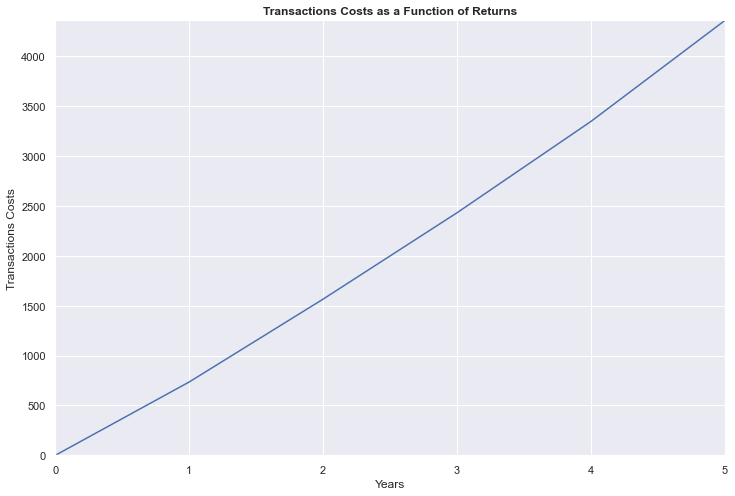

In [204]:
plt.plot(x,y)
plt.xlabel('Years')
plt.ylabel('Transactions Costs')
plt.title('Transactions Costs as a Function of Returns', fontweight='bold')

In [205]:
# Presentation of portfolio return data
col_names = ['Year 0','Year 1','Year 2','Year 3','Year 4','Year 5']
buy_and_hold_index_table = pd.DataFrame(buy_and_hold_index, columns=col_names)
buy_and_hold_index_table

,Year 0,Year 1,Year 2,Year 3,Year 4,Year 5
0,1.0,1.007873,1.044293,1.083617,1.339937,1.652491
1,1.0,1.093226,0.929499,1.020636,1.243759,1.338626
2,1.0,1.186204,1.382263,1.866678,1.968725,2.261020
3,1.0,1.021418,1.028630,1.139515,1.183830,1.467864
4,1.0,0.977628,0.989324,0.954308,1.059113,1.157729
...,...,...,...,...,...,...
4995,1.0,1.039851,1.170117,1.268659,1.458747,1.210429
4996,1.0,1.252672,1.446016,1.481745,1.573266,1.554797
4997,1.0,1.133797,0.953898,0.904447,0.975459,1.054376
4998,1.0,1.038539,1.279998,1.542388,1.528104,1.662364


In [212]:
"""
Define relevant constraints
"""

buy_and_hold_index_table
prices_5y = asset_prices[:,5]
cov_mat_5y = np.cov(prices_5y, rowvar=False)

"""
Define relevant constraints
"""
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x}

# alternatively use 
bounds = [(0.0, 1.0)] * 10

target_returns = np.arange(1.2, 1.3, 0.005) # this will depend on the returns of the simulated data. 
# target_returns = np.arange(1.3, 1.526, 0.025)

"""
Find optimal weights
"""

optimal_weights = list()
for target_return in target_returns:
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: np.average(prices_5y @ x) - target_return}


    x0 = np.ones(10) / 10.0
    res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat_5y,),
                                 method='SLSQP',
                                 constraints=[sum_to_one_cons, no_short_cons, target_cons], 
                                 options={'ftol': 1e-9, 'disp': True}, bounds=bounds)
    
    optimal_weights.append(res.x)
    
optimal_weights = np.array(optimal_weights)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.01300203958665791
            Iterations: 19
            Function evaluations: 210
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.013905718025078185
            Iterations: 18
            Function evaluations: 199
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.01486935217207155
            Iterations: 19
            Function evaluations: 209
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.015892941665083565
            Iterations: 18
            Function evaluations: 199
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.016976486759768483
            Iterations: 20
            

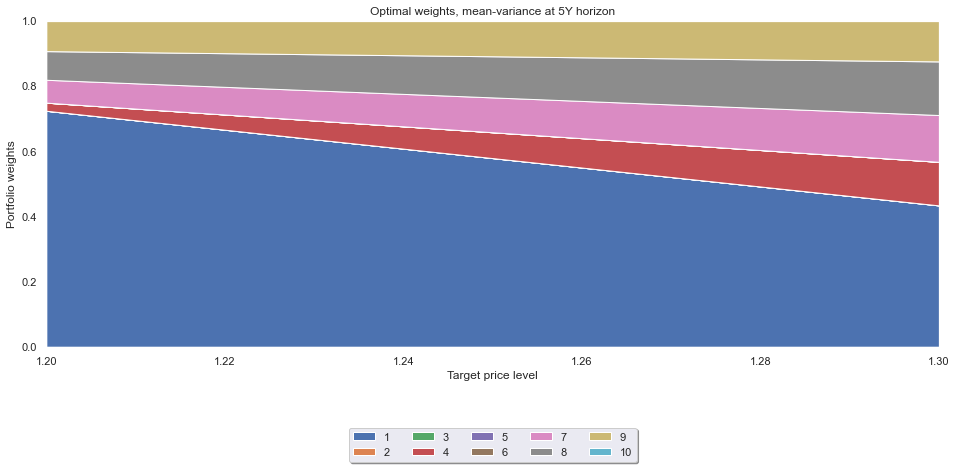

In [213]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.stackplot(target_returns, optimal_weights.T, labels=np.arange(1,11));
ax.set_xlabel("Target price level")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights, mean-variance at 5Y horizon")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5);

In [211]:
# calculate percentiles
percentiles_buy_and_hold = np.percentile(buy_and_hold_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)

'percentiles_constant_mix = np.percentile(constant_mix_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         'axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fan_chart(time_points,
          percentiles_buy_and_hold,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[0])

ax[0].set_xlabel("Year", size=15)
ax[0].set_ylabel("Index value", size=15)
ax[0].set_title("Buy and Hold", size=15)
ax[0].set_ylim([0.5, 3.0])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

'fan_chart(time_points,
          'percentiles_constant_mix,
          'color=default_colors['red'],
          'color_median=default_colors['dark_blue'],
          'labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          'ax=ax[1])

'ax[1].set_xlabel("Year", size=15)
'ax[1].set_title("Constant Mix", size=15)
'ax[1].set_ylim([0.5, 3.0])
'ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

SyntaxError: EOL while scanning string literal (<ipython-input-211-531fa2cc45bc>, line 5)

In [230]:
"""
Define quadratic utility function 
"""

def quadratic_utility(wealth: int) :
    
    """
    Function that returns the quadratic utility of a given allocation
    
    Parameters
    ----------
    weights: 
        Portfolio weights
    mu: 
        Expected returns
    cov_matrix: 
        Covariance matrix
    risk_aversion: 
        Risk aversion parameter
    
    Returns
    -------
    float
        Utility
    """
    return (wealth**gamma)/gamma